## ARIMA modeling time-series data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
df = pd.read_csv('./archive/POP.csv')
df['date'] = pd.to_datetime(df['date'])
df.drop(['realtime_start', 'realtime_end'], inplace=True, axis=1)
df.sort_values('date', inplace=True)
df.set_index('date', inplace=True)

print(df.shape)
df.head()

(816, 1)


,value
date,
1952-01-01,156309.0
1952-02-01,156527.0
1952-03-01,156731.0
1952-04-01,156943.0
1952-05-01,157140.0


## Figuring out the 'I' term

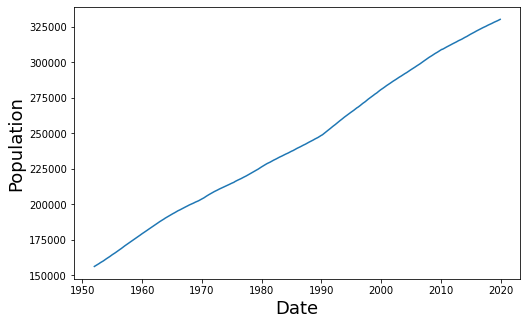

In [8]:
fig, ax = plt.subplots(1,1, figsize=(8,5))
ax.plot(df.value)
ax.set_xlabel('Date', fontsize=18)
ax.set_ylabel('Population', fontsize=18)
plt.savefig('initial-population-graph.png')

The plot of our population is gradually increasing over time. We need to manipulate our data so that it resembles a time series with stationarity. A time series has stationarity if it has constant standard deviation from a mean.

If we applied the Dickey-Fuller test to the data as-is, the test would result in non-stationarity by inspection. For the purpose of this example let's do that, and then apply the Dickey-Fuller test to the first, and possibly the second, differences of the data.

In [5]:
from statsmodels.tsa.stattools import adfuller

In [6]:
dftest = adfuller(df['value'], autolag='AIC')
adf_output = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key, value in dftest[4].items():
    adf_output['Critical Value ({0})'.format(key)] = value

adf_output

Test Statistic                  -0.665317
p-value                          0.855530
#Lags Used                      17.000000
Number of Observations Used    798.000000
Critical Value (1%)             -3.438571
Critical Value (5%)             -2.865169
Critical Value (10%)            -2.568702
dtype: float64

The p-value being significantly greater than 0.05 means that we can accept the null hypothesis of the test, meaning the data has non-stationarity (which was also evident from the above graph). Let's perform the Dickey-Fuller test for the first and second differences of the data and see the results.

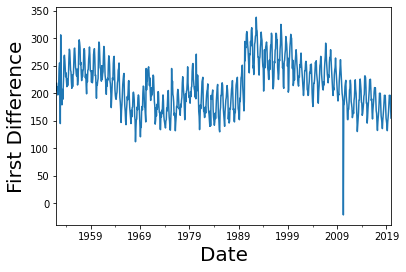

In [7]:
df['first_diff'] = df['value'].diff()
dftest2 = adfuller(df.first_diff.dropna())
adf_output2 = pd.Series(dftest2[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key, value in dftest2[4].items():
    adf_output2['Critical Value ({0})'.format(key)] = value

df.first_diff.plot(kind='line')
plt.xlabel('Date', fontsize=20)
plt.ylabel('First Difference', fontsize=20)
plt.savefig('first-difference.png')

The first difference is looking to be slightly more stationary. It appears to have a mean around 200-225ish; however, the standard deviation is obviously non-constant.

I expect the results of Dickey-Fuller to again tell us this data has non-stationarity, but with a significantly lower p-value than the non-differenced data.

In [8]:
adf_output2

Test Statistic                  -2.009895
p-value                          0.282251
#Lags Used                      21.000000
Number of Observations Used    793.000000
Critical Value (1%)             -3.438623
Critical Value (5%)             -2.865192
Critical Value (10%)            -2.568714
dtype: float64

The p-value is 0.28, meaning the test proved the first difference to have non-stationarity. Looking at the data, we suspect that the second difference might have some stationarity to it since the first difference tends to center around a specific mean.

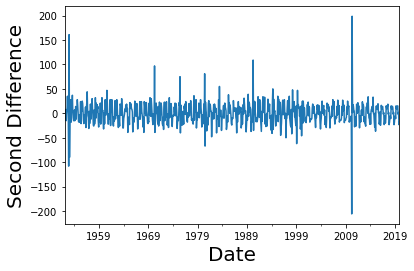

In [9]:
df['second_diff'] = df.first_diff.diff()
dftest3 = adfuller(df.second_diff.dropna())
adf_output3 = pd.Series(dftest3[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key, value in dftest3[4].items():
    adf_output3['Critical Value ({0})'.format(key)] = value

df.second_diff.plot(kind='line')
plt.xlabel('Date', fontsize=20)
plt.ylabel('Second Difference', fontsize=20)
plt.savefig('second-difference.png')

In [10]:
adf_output3

Test Statistic                -7.221128e+00
p-value                        2.110012e-10
#Lags Used                     2.100000e+01
Number of Observations Used    7.920000e+02
Critical Value (1%)           -3.438634e+00
Critical Value (5%)           -2.865196e+00
Critical Value (10%)          -2.568717e+00
dtype: float64

The graph above is more telling of a time series with stationarity. It has an obvious mean of around 0 and doesn't have any clear trends other than spiking up and down. So it has constant variance from inspection. Furthermore, the Dickey-Fuller test has a p-value < 0.05, telling us the data is stationary.

Based on the above information, it is quite possible we are going to roll with a value of d=2 for our ARIMA(p,d,q) model. Now we plot the ACF for the second difference.

## Finding the 'p' term

The 'p' term in the ARIMA(p,d,q) model tells us how many time periods of lag we are going to use to predict values in our time series data. In order to find p, we are going to look at the plot of the Autocorrelation Function (ACF). The ACF tells us how correlated the values in a time series are with each other. On the y-axis we plot the correlation coefficient, and on the x-axis we plot the amount of lag which is measured in units of time for the time series. We have measures of population for each month in our data, so 1 value of lag is one month in the past.

## ACF Graphs
Let's plot the ACF for the first and second differences which we have graphs of above.

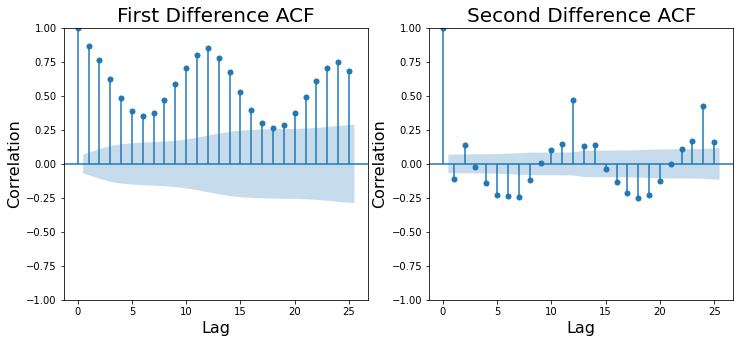

In [18]:
from statsmodels.graphics.tsaplots import plot_acf

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))
plot_acf(df.first_diff.dropna(), lags=25, ax=ax1)
ax1.set_title('First Difference ACF', fontsize=20)
ax1.set_xlabel('Lag', fontsize=16)
ax1.set_ylabel('Correlation',fontsize=16)
plot_acf(df.second_diff.dropna(), lags=25, ax=ax2)
ax2.set_title('Second Difference ACF', fontsize=20)
ax2.set_ylabel('Correlation',fontsize=16)
ax2.set_xlabel('Lag',fontsize=16)
plt.savefig('acf.png')
plt.show()

To clarify, for a lag of 0 the ACF will always have a value of 1. The data points will always perfectly correlate with themselves with 0 errors.

Looking at the First Difference ACF graph, we can detect some seasonality in the population time series. The plot resembles a sinusoidal graph with a peak after every 12 periods of lag. This plot suggetss that just about any value of 'p' up to 25 would work well, as the data correlates with itself for various periods of lag. This tells me that if we were to use the first difference in our ARIMA model we would be able to experiment with different values of 'p'.

From the second difference ACF plot, this tells me that our data is probably *over-differenced*. I say this because at a lag of 1 we immediately have a negative ACF value. A negative ACF value in this context means that if we were to have our population increasing at one point in time, it is highly likely that at the next period of time our population will be decreasing. Knowing the nature of our dataset, this does not make sense since the population seems to be rising at a constant rate. So the ACF graphs suggest using the first difference for ARIMA, or a value of d=1.

Thus we are stuck in a sort-of middle ground here in terms of the first and second difference. While the first difference isn't differenced enough and also displays some seasonality, the second difference is over-differenced. We would prefer to use the data that is slightly under-differenced to the data that is over-differenced when trying to make predictions.

## PACF graphs

The PACF graphs are the 'Partial Autocorrelation Function' graphs. The PACF function displays the correlation between a variable and its lagged values after controlling the effects of other lagges variables. It captures the correlation between a series and its lagged values that aren't already displayed by other lagged variables. 

This might help us narrow down what value of 'p' to actually use in our model since we concluded that a lot of values could work from our 1st Difference ACF plot.

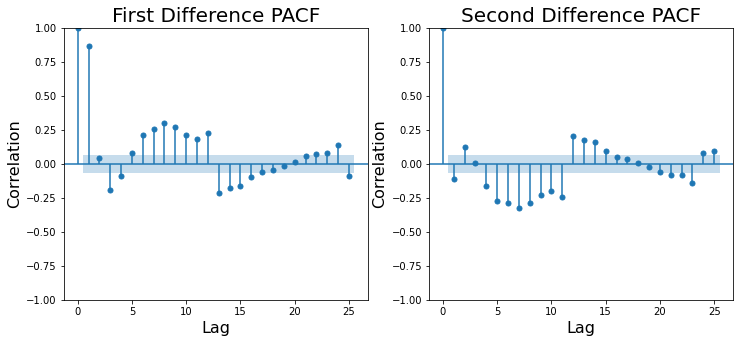

In [19]:
from statsmodels.graphics.tsaplots import plot_pacf

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))
plot_pacf(df.first_diff.dropna(), lags=25, ax=ax1, method='ywm')
ax1.set_title('First Difference PACF',fontsize=20)
ax1.set_xlabel('Lag',fontsize=16)
ax1.set_ylabel('Correlation',fontsize=16)
plot_pacf(df.second_diff.dropna(), lags=25, ax=ax2, method='ywm')
ax2.set_title('Second Difference PACF',fontsize=20)
ax2.set_ylabel('Correlation',fontsize=16)
ax2.set_xlabel('Lag',fontsize=16)
plt.savefig('pacf.png')
plt.show()

Looking at the PACF plot for the first difference only the first lagged value has a significant correlation with current values. Since the correlation for other lagged values is so low, this tells us that the correlation between other lagged values and the current value in our ACF plot can simply be explained by only the first lagged value.

## Finding the 'q' term

Finding the best value for q involves looking at points that are significantly above the significance level for the ACF plot. We have a lot of points that are above the significance level (shaded blue area), so let's try out our model with values of q=1 and q=2.

## Building the models

In [13]:
from statsmodels.tsa.arima.model import ARIMA
ar1 = ARIMA(df['first_diff'], order=(1,0,1)).fit()
ar2 = ARIMA(df['first_diff'], order=(1,0,2)).fit()

C:\Users\cbarg\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\cbarg\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\cbarg\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\cbarg\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\Local

In [14]:
ar1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             first_diff   No. Observations:                  816
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -3670.140
Date:                Sun, 17 Apr 2022   AIC                           7348.280
Time:                        20:42:07   BIC                           7367.098
Sample:                    01-01-1952   HQIC                          7355.502
                         - 12-01-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        213.4934      6.337     33.688      0.000     201.073     225.914
ar.L1          0.8759      0.022     39.382      0.000       0.832       0.919
ma.L1         -0.0353      0.028     -1.277      0.201      -0.089       0.019
sigma2       476.6707      8.992     53.010      0.000     459.047     494.295
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):              9956.14
Prob(Q):                              0.88   Prob(JB):                         0.00
Heteroskedasticity (H):               1.11   Skew:                            -0.08
Prob(H) (two-sided):                  0.37   Kurtosis:                        20.11
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [15]:
ar2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             first_diff   No. Observations:                  816
Model:                 ARIMA(1, 0, 2)   Log Likelihood               -3652.104
Date:                Sun, 17 Apr 2022   AIC                           7314.208
Time:                        20:42:08   BIC                           7337.730
Sample:                    01-01-1952   HQIC                          7323.236
                         - 12-01-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        213.4933      5.775     36.971      0.000     202.175     224.811
ar.L1          0.8329      0.026     31.785      0.000       0.781       0.884
ma.L1         -0.0393      0.030     -1.323      0.186      -0.098       0.019
ma.L2          0.2329      0.032      7.211      0.000       0.170       0.296
sigma2       455.9953      8.249     55.279      0.000     439.828     472.163
===================================================================================
Ljung-Box (L1) (Q):                   0.54   Jarque-Bera (JB):             10822.65
Prob(Q):                              0.46   Prob(JB):                         0.00
Heteroskedasticity (H):               1.12   Skew:                            -0.11
Prob(H) (two-sided):                  0.37   Kurtosis:                        20.84
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

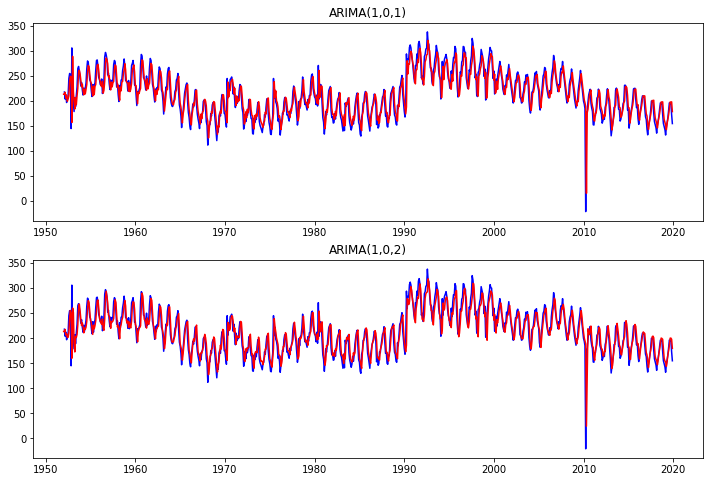

In [16]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
ax1.plot(df.value.diff().dropna(), color='blue')
preds1 = ar1.fittedvalues
ax1.plot(preds1, color='red')
ax1.set_title('ARIMA(1,0,1)')
ax2.plot(df.value.diff().dropna(), color='blue')
preds2 = ar2.fittedvalues
ax2.plot(preds2, color='red')
ax2.set_title('ARIMA(1,0,2)')
plt.savefig('fitting-models.png')


To see how the methods compare, let's take a look at their errors:

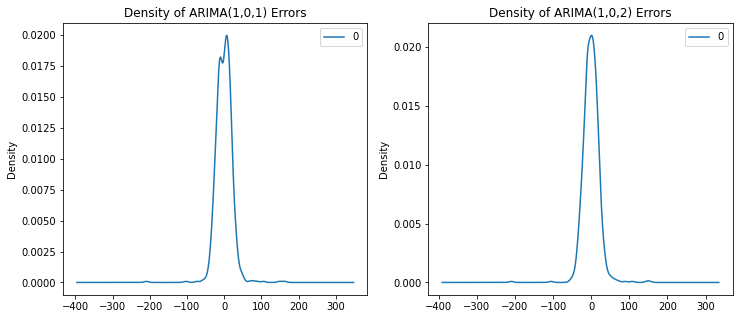

In [20]:
residuals1 = pd.DataFrame(ar1.resid)
residuals2 = pd.DataFrame(ar2.resid)

fig,axs = plt.subplots(1,2, figsize=(12,5))
residuals1.plot(kind='kde', title='Density of ARIMA(1,0,1) Errors', ax=axs[0])
residuals2.plot(kind='kde', title='Density of ARIMA(1,0,2) Errors', ax=axs[1])
plt.savefig('error-density.png')
plt.show()

The density plots of the errors are very similar. I do not think it matters which model we choose.

In [21]:
df.shape

(816, 3)

In [22]:
train = df.value[:650]
test = df.value[650:]

model1 = ARIMA(train, order=(1,1,2))
model_fitted1 = model1.fit()

C:\Users\cbarg\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\cbarg\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\cbarg\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [23]:
forecast = model_fitted1.get_forecast(steps=166).summary_frame()

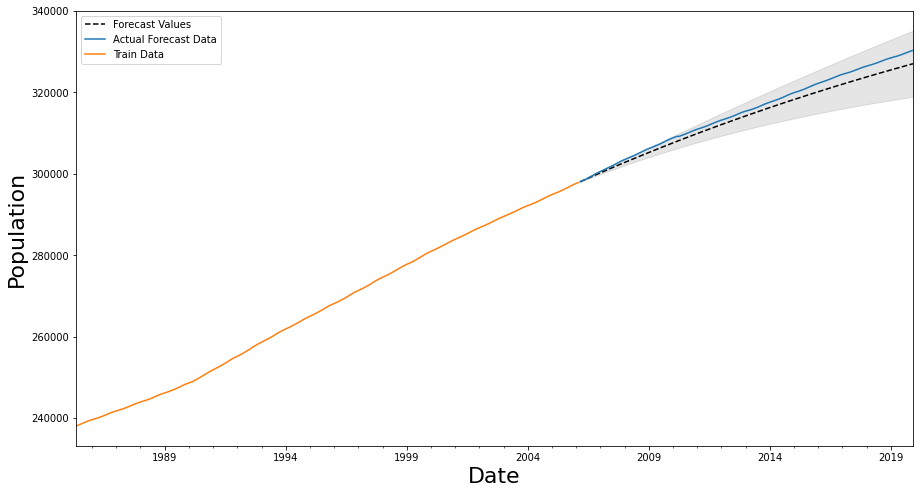

In [24]:
fig, ax = plt.subplots(figsize=(15,8))

forecast['mean'].plot(ax=ax, style='k--', label='Forecast Values')
ax.fill_between(forecast.index, forecast['mean_ci_lower'], forecast['mean_ci_upper'], color='k', alpha=0.1)
test.plot(label='Actual Forecast Data')
train[400:].plot(label='Train Data')
ax.set_xlabel('Date', fontsize=22)
ax.set_ylabel('Population', fontsize=22)

plt.legend()
plt.savefig('forecast.png')